# PrithviWxC

This notebook will walk you through how to construct the model,
load the weights, build the dataset, and use the model for inference.

In [21]:
import random
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import torch
from huggingface_hub import hf_hub_download, snapshot_download

We now configure the backends and torch states, including setting the seeds for the RNGs.

In [22]:
torch.jit.enable_onednn_fusion(True)
if torch.cuda.is_available():
    print(f"Using device: {torch.cuda.get_device_name()}")
    torch.backends.cudnn.benchmark = True
    torch.backends.cudnn.deterministic = True

random.seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
torch.manual_seed(42)
np.random.seed(42)

The model has approximately 2.3 billion parameters, so it
requires reasonable computational resources, but it is possible
to run it on a CPU.

In [23]:
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

## Dataloader
### Variables and times

With the environment ready to go, we now need to set up the task.
The core model expects a fixed set of variables from the MERRA-2
dataset, which are prescribed below. The variables are comprised
of surface variables, surface static variables, and variables at
various vertical levels within the atmosphere. More details on the
MERRA-2 dataset can be found
[here](https://gmao.gsfc.nasa.gov/reanalysis/MERRA-2/).

The MERRA-2 dataset includes data at longitudes of $-180^\circ$
and $+180^\circ$. This represents duplicate data, so we set a
padding variable to remove it.

The input to the core model consists of these variables at two
different times. The time difference in hours between these samples
is passed to the model and set in the input_time variable.

The model's task is to predict the fixed set of variables at a
target time, given the input data.

For example, if the input times are 0900 and 1200, resulting in
an input_time of -3, then a lead_time of 6 would result in a
target time of 1800.

In [24]:
surface_vars = [
    "EFLUX",
    "GWETROOT",
    "HFLUX",
    "LAI",
    "LWGAB",
    "LWGEM",
    "LWTUP",
    "PS",
    "QV2M",
    "SLP",
    "SWGNT",
    "SWTNT",
    "T2M",
    "TQI",
    "TQL",
    "TQV",
    "TS",
    "U10M",
    "V10M",
    "Z0M",
]
static_surface_vars = ["FRACI", "FRLAND", "FROCEAN", "PHIS"]
vertical_vars = ["CLOUD", "H", "OMEGA", "PL", "QI", "QL", "QV", "T", "U", "V"]
levels = [
    34.0,
    39.0,
    41.0,
    43.0,
    44.0,
    45.0,
    48.0,
    51.0,
    53.0,
    56.0,
    63.0,
    68.0,
    71.0,
    72.0,
]
padding = {"level": [0, 0], "lat": [0, -1], "lon": [0, 0]}

lead_times = [12]  # This varibale can be change to change the task
input_times = [-6]  # This varibale can be change to change the task

### Data file
MERRA-2 data is available from 1980 to the present day,
at 3-hour temporal resolution. The dataloader we have provided
expects the surface data and vertical data to be saved in
separate files, and when provided with the directories, will
search for the relevant data that falls within the provided time range.


In [25]:
time_range = ("2020-01-01T00:00:00", "2020-01-01T23:59:59")

surf_dir = Path("./merra-2")
snapshot_download(
    repo_id="Prithvi-WxC/prithvi.wxc.2300m.v1",
    allow_patterns="merra-2/MERRA2_sfc_2020010[1].nc",
    local_dir=".",
)

vert_dir = Path("./merra-2")
snapshot_download(
    repo_id="Prithvi-WxC/prithvi.wxc.2300m.v1",
    allow_patterns="merra-2/MERRA_pres_2020010[1].nc",
    local_dir=".",
)

Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

'C:\\Users\\Quan\\Documents\\Prithvi-Forecast\\Prithvi-WxC\\examples'

### Climatology
The PrithviWxC model was trained to calculate the output by
producing a perturbation to the climatology at the target time.
 This mode of operation is set via the `residual=climate` option.
 This was chosen as climatology is typically a strong prior for
 long-range prediction. When using the `residual=climate` option,
 we have to provide the dataloader with the path of the
 climatology data.

In [26]:
surf_clim_dir = Path("./climatology")
snapshot_download(
    repo_id="Prithvi-WxC/prithvi.wxc.2300m.v1",
    allow_patterns="climatology/climate_surface_doy00[1]*.nc",
    local_dir=".",
)

vert_clim_dir = Path("./climatology")
snapshot_download(
    repo_id="Prithvi-WxC/prithvi.wxc.2300m.v1",
    allow_patterns="climatology/climate_vertical_doy00[1]*.nc",
    local_dir=".",
)

Fetching 8 files:   0%|          | 0/8 [00:00<?, ?it/s]

Fetching 8 files:   0%|          | 0/8 [00:00<?, ?it/s]

'C:\\Users\\Quan\\Documents\\Prithvi-Forecast\\Prithvi-WxC\\examples'

### Postion encoding
Position data is included in the data passed to the model,
as this allows the attention mechanism to determine data
locality rather than explicit or implicit data connections.
The position data is encoded in the model with two possible
options, fourier or absolute. As these encoding options
require different treatment within the data loader, the
chosen option is set here.

In [27]:
positional_encoding = "fourier"

### Dataset init
We can now instantiate the MERRA2 Dataset class provided.

In [28]:
import functools as ft
import os
import random
import re
from collections import defaultdict
from datetime import datetime, timedelta
from pathlib import Path

import h5py
import numpy as np
import pandas as pd
import torch
from torch import Tensor
from torch.utils.data import Dataset


def preproc(batch: list[dict], padding: dict[tuple[int]]) -> dict[str, Tensor]:
    """Prepressing function for MERRA2 Dataset

    Args:
        batch (dict): List of training samples, each sample should be a
            dictionary with the following keys::

            'sur_static': Numpy array of shape (3, lat, lon). For each pixel (lat, lon), the first dimension indexes sin(lat), cos(lon), sin(lon).
            'sur_vals': Torch tensor of shape (parameter, time, lat, lon).
            'sur_tars': Torch tensor of shape (parameter, time, lat, lon).
            'ulv_vals': Torch tensor of shape (parameter, level, time, lat, lon).
            'ulv_tars': Torch tensor of shape (parameter, level, time, lat, lon).
            'sur_climate': Torch tensor of shape (parameter, lat, lon)
            'ulv_climate': Torch tensor of shape (parameter, level, lat, lon)
            'lead_time': Integer.
            'input_time': Integer.

        padding: Dictionary with keys 'level', 'lat', 'lon', each of dim 2.

    Returns:
        Dictionary with the following keys::

            'x': [batch, time, parameter, lat, lon]
            'y': [batch, parameter, lat, lon]
            'static': [batch, parameter, lat, lon]
            'lead_time': [batch]
            'input_time': [batch]
            'climate (Optional)': [batch, parameter, lat, lon]

    Note:
        Here, for x and y, 'parameter' is [surface parameter, upper level,
        parameter x level]. Similarly for the static information we have
        [sin(lat), cos(lon), sin(lon), cos(doy), sin(doy), cos(hod), sin(hod),
        ...].
    """  # noqa: E501
    b0 = batch[0]
    nbatch = len(batch)
    data_keys = set(b0.keys())

    essential_keys = {
        "sur_static",
        "sur_vals",
        "sur_tars",
        "ulv_vals",
        "ulv_tars",
        "input_time",
        "lead_time",
    }

    climate_keys = {
        "sur_climate",
        "ulv_climate",
    }

    all_keys = essential_keys | climate_keys

    if not essential_keys.issubset(data_keys):
        raise ValueError("Missing essential keys.")

    if not data_keys.issubset(all_keys):
        raise ValueError("Unexpected keys in batch.")

    # Bring all tensors from the batch into a single tensor
    upl_x = torch.empty((nbatch, *b0["ulv_vals"].shape))
    upl_y = torch.empty((nbatch, *b0["ulv_tars"].shape))

    sur_x = torch.empty((nbatch, *b0["sur_vals"].shape))
    sur_y = torch.empty((nbatch, *b0["sur_tars"].shape))

    sur_sta = torch.empty((nbatch, *b0["sur_static"].shape))

    lead_time = torch.empty((nbatch,), dtype=torch.float32)
    input_time = torch.empty((nbatch,), dtype=torch.float32)

    for i, rec in enumerate(batch):
        sur_x[i] = rec["sur_vals"]
        sur_y[i] = rec["sur_tars"]

        upl_x[i] = rec["ulv_vals"]
        upl_y[i] = rec["ulv_tars"]

        sur_sta[i] = rec["sur_static"]

        lead_time[i] = rec["lead_time"]
        input_time[i] = rec["input_time"]

    return_value = {
        "lead_time": lead_time,
        "input_time": input_time,
    }

    # Reshape (batch, parameter, level, time, lat, lon) ->
    #  (batch, time, parameter, level, lat, lon)
    upl_x = upl_x.permute((0, 3, 1, 2, 4, 5))
    upl_y = upl_y.permute((0, 3, 1, 2, 4, 5))
    # Reshape (batch, parameter, time, lat, lon) ->
    #  (batch, time, parameter, lat, lon)
    sur_x = sur_x.permute((0, 2, 1, 3, 4))
    sur_y = sur_y.permute((0, 2, 1, 3, 4))

    # Pad
    padding_2d = (*padding["lon"], *padding["lat"])

    def pad2d(x):
        return torch.nn.functional.pad(x, padding_2d, mode="constant", value=0)

    padding_3d = (*padding["lon"], *padding["lat"], *padding["level"])

    def pad3d(x):
        return torch.nn.functional.pad(x, padding_3d, mode="constant", value=0)

    sur_x = pad2d(sur_x).contiguous()
    upl_x = pad3d(upl_x).contiguous()
    sur_y = pad2d(sur_y).contiguous()
    upl_y = pad3d(upl_y).contiguous()
    return_value["static"] = pad2d(sur_sta).contiguous()

    # Remove time for targets
    upl_y = torch.squeeze(upl_y, 1)
    sur_y = torch.squeeze(sur_y, 1)

    # We stack along the combined parameter x level dimension
    return_value["x"] = torch.cat(
        (sur_x, upl_x.view(*upl_x.shape[:2], -1, *upl_x.shape[4:])), dim=2
    )
    return_value["y"] = torch.cat(
        (sur_y, upl_y.view(upl_y.shape[0], -1, *upl_y.shape[3:])), dim=1
    )

    if climate_keys.issubset(data_keys):
        sur_climate = torch.empty((nbatch, *b0["sur_climate"].shape))
        ulv_climate = torch.empty((nbatch, *b0["ulv_climate"].shape))
        for i, rec in enumerate(batch):
            sur_climate[i] = rec["sur_climate"]
            ulv_climate[i] = rec["ulv_climate"]
        sur_climate = pad2d(sur_climate)
        ulv_climate = pad3d(ulv_climate)

        return_value["climate"] = torch.cat(
            (
                sur_climate,
                ulv_climate.view(nbatch, -1, *ulv_climate.shape[3:]),
            ),
            dim=1,
        )

    return return_value


def input_scalers(
    surf_vars: list[str],
    vert_vars: list[str],
    levels: list[float],
    surf_path: str | Path,
    vert_path: str | Path,
) -> tuple[Tensor, Tensor]:
    """Reads the input scalers

    Args:
        surf_vars: surface variables to be used.
        vert_vars: vertical variables to be used.
        levels: MERRA2 levels to use.
        surf_path: path to surface scalers file.
        vert_path: path to vertical level scalers file.

    Returns:
        mu (Tensor): mean values
        var (Tensor): varience values
    """
    with h5py.File(Path(surf_path), "r", libver="latest") as surf_file:
        stats = [x.decode().lower() for x in surf_file["statistic"][()]]
        mu_idx = stats.index("mu")
        sig_idx = stats.index("sigma")

        s_mu = torch.tensor([surf_file[k][()][mu_idx] for k in surf_vars])
        s_sig = torch.tensor([surf_file[k][()][sig_idx] for k in surf_vars])

    with h5py.File(Path(vert_path), "r", libver="latest") as vert_file:
        stats = [x.decode().lower() for x in vert_file["statistic"][()]]
        mu_idx = stats.index("mu")
        sig_idx = stats.index("sigma")

        lvl = vert_file["lev"][()]
        l_idx = [np.where(lvl == v)[0].item() for v in levels]

        v_mu = np.array([vert_file[k][()][mu_idx, l_idx] for k in vert_vars])
        v_sig = np.array([vert_file[k][()][sig_idx, l_idx] for k in vert_vars])

    v_mu = torch.from_numpy(v_mu).view(-1)
    v_sig = torch.from_numpy(v_sig).view(-1)

    mu = torch.cat((s_mu, v_mu), dim=0).to(torch.float32)
    sig = torch.cat((s_sig, v_sig), dim=0).to(torch.float32).clamp(1e-4, 1e4)
    return mu, sig


def static_input_scalers(
    scalar_path: str | Path, stat_vars: list[str], unscaled_params: int = 7
) -> tuple[Tensor, Tensor]:
    scalar_path = Path(scalar_path)

    with h5py.File(scalar_path, "r", libver="latest") as scaler_file:
        stats = [x.decode().lower() for x in scaler_file["statistic"][()]]
        mu_idx = stats.index("mu")
        sig_idx = stats.index("sigma")

        mu = torch.tensor([scaler_file[k][()][mu_idx] for k in stat_vars])
        sig = torch.tensor([scaler_file[k][()][sig_idx] for k in stat_vars])

    z = torch.zeros(unscaled_params, dtype=mu.dtype, device=mu.device)
    o = torch.ones(unscaled_params, dtype=sig.dtype, device=sig.device)
    mu = torch.cat((z, mu), dim=0).to(torch.float32)
    sig = torch.cat((o, sig), dim=0).to(torch.float32)

    return mu, sig.clamp(1e-4, 1e4)


def output_scalers(
    surf_vars: list[str],
    vert_vars: list[str],
    levels: list[float],
    surf_path: str | Path,
    vert_path: str | Path,
) -> Tensor:
    surf_path = Path(surf_path)
    vert_path = Path(vert_path)

    with h5py.File(surf_path, "r", libver="latest") as surf_file:
        svars = torch.tensor([surf_file[k][()] for k in surf_vars])

    with h5py.File(vert_path, "r", libver="latest") as vert_file:
        lvl = vert_file["lev"][()]
        l_idx = [np.where(lvl == v)[0].item() for v in levels]
        vvars = np.array([vert_file[k][()][l_idx] for k in vert_vars])
    vvars = torch.from_numpy(vvars).view(-1)

    var = torch.cat((svars, vvars), dim=0).to(torch.float32).clamp(1e-7, 1e7)

    return var


class SampleSpec:
    """
    A data class to collect the information used to define a sample.
    """

    def __init__(
        self,
        inputs: tuple[pd.Timestamp, pd.Timestamp],
        lead_time: int,
        target: pd.Timestamp | list[pd.Timestamp],
    ):
        """
        Args:
            inputs: Tuple of timestamps. In ascending order.
            lead_time: Lead time. In hours.
            target: Timestamp of the target. Can be before or after the inputs.
        """
        if not inputs[0] < inputs[1]:
            raise ValueError(
                "Timestamps in `inputs` should be in strictly ascending order."
            )

        self.inputs = inputs
        self.input_time = (inputs[1] - inputs[0]).total_seconds() / 3600
        self.lead_time = lead_time
        self.target = target

        self.times = [*inputs, target]
        self.stat_times = [inputs[-1]]

    @property
    def climatology_info(self) -> tuple[int, int]:
        """Get the required climatology info.

        :return: information required to obtain climatology data. Essentially
            this is the day of the year and hour of the day of the target
            timestamp, with the former restricted to the interval [1, 365].
        :rtype: tuple
        """
        return (min(self.target.dayofyear, 365), self.target.hour)

    @property
    def year(self) -> int:
        return self.inputs[1].year

    @property
    def dayofyear(self) -> int:
        return self.inputs[1].dayofyear

    @property
    def hourofday(self) -> int:
        return self.inputs[1].hour

    def _info_str(self) -> str:
        iso_8601 = "%Y-%m-%dT%H:%M:%S"

        return (
            f"Issue time: {self.inputs[1].strftime(iso_8601)}\n"
            f"Lead time: {self.lead_time} hours ahead\n"
            f"Input delta: {self.input_time} hours\n"
            f"Target time: {self.target.strftime(iso_8601)}"
        )

    @classmethod
    def get(cls, timestamp: pd.Timestamp, dt: int, lead_time: int):
        """Given a timestamp and lead time, generates a SampleSpec object
        describing the sample further.

        Args:
            timestamp: Timstamp of the sample, Ie this is the larger of the two
                input timstamps.
            dt: Time between input samples, in hours.
            lead_time: Lead time. In hours.

        Returns:
            SampleSpec
        """  # noqa: E501
        assert dt > 0, "dt should be possitive"
        lt = pd.to_timedelta(lead_time, unit="h")
        dt = pd.to_timedelta(dt, unit="h")

        if lead_time >= 0:
            timestamp_target = timestamp + lt
        else:
            timestamp_target = timestamp - dt + lt

        spec = cls(
            inputs=(timestamp - dt, timestamp),
            lead_time=lead_time,
            target=timestamp_target,
        )

        return spec

    def __repr__(self) -> str:
        return self._info_str()

    def __str__(self) -> str:
        return self._info_str()


class Merra2Dataset(Dataset):
    """MERRA2 dataset. The dataset unifies surface and vertical data as well as
    optional climatology.

    Samples come in the form of a dictionary. Not all keys support all
    variables, yet the general ordering of dimensions is
    parameter, level, time, lat, lon

    Note:
        Data is assumed to be in NetCDF files containing daily data at 3-hourly
        intervals. These follow the naming patterns
        MERRA2_sfc_YYYYMMHH.nc and MERRA_pres_YYYYMMHH.nc and can be located in
        two different locations. Optional climatology data comes from files
        climate_surface_doyDOY_hourHOD.nc and
        climate_vertical_doyDOY_hourHOD.nc.


    Note:
        `_get_valid_timestamps` assembles a set of all timestamps for which
        there is data (with hourly resolutions). The result is stored in
        `_valid_timestamps`. `_get_valid_climate_timestamps` does the same with
        climatology data and stores it in `_valid_climate_timestamps`.

        Based on this information, `samples` generates a list of valid samples,
        stored in `samples`. Here the format is::

            [
                [
                    (timestamp 1, lead time A),
                    (timestamp 1, lead time B),
                    (timestamp 1, lead time C),
                ],
                [
                    (timestamp 2, lead time D),
                    (timestamp 2, lead time E),
                ]
            ]

        That is, the outer list iterates over timestamps (init times), the
        inner over lead times. Only valid entries are stored.
    """

    valid_vertical_vars = [
        "CLOUD",
        "H",
        "OMEGA",
        "PL",
        "QI",
        "QL",
        "QV",
        "T",
        "U",
        "V",
    ]
    valid_surface_vars = [
        "EFLUX",
        "GWETROOT",
        "HFLUX",
        "LAI",
        "LWGAB",
        "LWGEM",
        "LWTUP",
        "PRECTOT",
        "PS",
        "QV2M",
        "SLP",
        "SWGNT",
        "SWTNT",
        "T2M",
        "TQI",
        "TQL",
        "TQV",
        "TS",
        "U10M",
        "V10M",
        "Z0M",
    ]
    valid_static_surface_vars = ["FRACI", "FRLAND", "FROCEAN", "PHIS"]

    valid_levels = [
        34.0,
        39.0,
        41.0,
        43.0,
        44.0,
        45.0,
        48.0,
        51.0,
        53.0,
        56.0,
        63.0,
        68.0,
        71.0,
        72.0,
    ]

    timedelta_input = pd.to_timedelta(3, unit="h")

    def __init__(
        self,
        time_range: tuple[str | pd.Timestamp, str | pd.Timestamp],
        lead_times: list[int],
        input_times: list[int],
        data_path_surface: str | Path,
        data_path_vertical: str | Path,
        climatology_path_surface: str | Path | None = None,
        climatology_path_vertical: str | Path | None = None,
        surface_vars: list[str] | None = None,
        static_surface_vars: list[str] | None = None,
        vertical_vars: list[str] | None = None,
        levels: list[float] | None = None,
        roll_longitudes: int = 0,
        positional_encoding: str = "absolute",
        rtype: type = np.float32,
        dtype: torch.dtype = torch.float32,
    ) -> None:
        """
        Args:
            data_path_surface: Location of surface data.
            data_path_vertical: Location of vertical data.
            climatology_path_surface: Location of (optional) surface
                climatology.
            climatology_path_vertical: Location of (optional) vertical
                climatology.
            surface_vars: Surface variables.
            static_surface_vars: Static surface variables.
            vertical_vars: Vertical variables.
            levels: Levels.
            time_range: Used to subset data.
            lead_times: Lead times for generalized forecasting.
            roll_longitudes: Set to non-zero value to data by random amount
                along longitude dimension.
            position_encoding: possible values are
              ['absolute' (default), 'fourier'].
                'absolute' returns lat lon encoded in 3 dimensions using sine
                  and cosine
                'fourier' returns lat/lon to be encoded by model
                <any other key> returns lat/lon to be encoded by model
            rtype: numpy data type used during read
            dtype: torch data type of data output
        """

        self.time_range = (
            pd.to_datetime(time_range[0]),
            pd.to_datetime(time_range[1]),
        )
        self.lead_times = lead_times
        self.input_times = input_times
        self._roll_longitudes = list(range(roll_longitudes + 1))

        self._uvars = vertical_vars or self.valid_vertical_vars
        self._level = levels or self.valid_levels
        self._svars = surface_vars or self.valid_surface_vars
        self._sstat = static_surface_vars or self.valid_static_surface_vars
        self._nuvars = len(self._uvars)
        self._nlevel = len(self._level)
        self._nsvars = len(self._svars)
        self._nsstat = len(self._sstat)

        self.rtype = rtype
        self.dtype = dtype

        self.positional_encoding = positional_encoding

        self._data_path_surface = Path(data_path_surface)
        self._data_path_vertical = Path(data_path_vertical)

        self.dir_exists(self._data_path_surface)
        self.dir_exists(self._data_path_vertical)

        self._get_coordinates()

        self._climatology_path_surface = Path(climatology_path_surface) or None
        self._climatology_path_vertical = (
            Path(climatology_path_vertical) or None
        )
        self._require_clim = (
            self._climatology_path_surface is not None
            and self._climatology_path_vertical is not None
        )

        if self._require_clim:
            self.dir_exists(self._climatology_path_surface)
            self.dir_exists(self._climatology_path_vertical)
        elif (
            climatology_path_surface is None
            and climatology_path_vertical is None
        ):
            self._climatology_path_surface = None
            self._climatology_path_vertical = None
        else:
            raise ValueError(
                "Either both or neither of"
                "`climatology_path_surface` and"
                "`climatology_path_vertical` should be None."
            )

        if not set(self._svars).issubset(set(self.valid_surface_vars)):
            raise ValueError("Invalid surface variable.")

        if not set(self._sstat).issubset(set(self.valid_static_surface_vars)):
            raise ValueError("Invalid static surface variable.")

        if not set(self._uvars).issubset(set(self.valid_vertical_vars)):
            raise ValueError("Inalid vertical variable.")

        if not set(self._level).issubset(set(self.valid_levels)):
            raise ValueError("Invalid level.")

    @staticmethod
    def dir_exists(path: Path) -> None:
        if not path.is_dir():
            raise ValueError(f"Directory {path} does not exist.")

    @property
    def upper_shape(self) -> tuple:
        """Returns the vertical variables shape
        Returns:
            tuple: vertical variable shape in the following order::

                [VAR, LEV, TIME, LAT, LON]
        """
        return self._nuvars, self._nlevel, 2, 361, 576

    @property
    def surface_shape(self) -> tuple:
        """Returns the surface variables shape

        Returns:
            tuple: surafce shape in the following order::

                [VAR, LEV, TIME, LAT, LON]
        """
        return self._nsvars, 2, 361, 576

    def data_file_surface(self, timestamp: pd.Timestamp) -> Path:
        """Build the surfcae data file name based on timestamp

        Args:
            timestamp: a timestamp

        Returns:
            Path: constructed path
        """
        pattern = "MERRA2_sfc_%Y%m%d.nc"
        data_file = self._data_path_surface / timestamp.strftime(pattern)
        return data_file

    def data_file_vertical(self, timestamp: pd.Timestamp) -> Path:
        """Build the vertical data file name based on timestamp

        Args:
            timestamp: a timestamp

        Returns:
            Path: constructed path
        """
        pattern = "MERRA_pres_%Y%m%d.nc"
        data_file = self._data_path_vertical / timestamp.strftime(pattern)
        return data_file

    def data_file_surface_climate(
        self,
        timestamp: pd.Timestamp | None = None,
        dayofyear: int | None = None,
        hourofday: int | None = None,
    ) -> Path:
        """
        Returns the path to a climatology file based either on a timestamp or
        the dayofyear / hourofday combination.
        Args:
            timestamp: A timestamp.
            dayofyear: Day of the year. 1 to 366.
            hourofday: Hour of the day. 0 to 23.
        Returns:
            Path: Path to climatology file.
        """
        if timestamp is not None and (
            (dayofyear is not None) or (hourofday is not None)
        ):
            raise ValueError(
                "Provide either timestamp or both dayofyear and hourofday."
            )

        if timestamp is not None:
            dayofyear = min(timestamp.dayofyear, 365)
            hourofday = timestamp.hour

        file_name = f"climate_surface_doy{dayofyear:03}_hour{hourofday:02}.nc"
        data_file = self._climatology_path_surface / file_name
        return data_file

    def data_file_vertical_climate(
        self,
        timestamp: pd.Timestamp | None = None,
        dayofyear: int | None = None,
        hourofday: int | None = None,
    ) -> Path:
        """Returns the path to a climatology file based either on a timestamp
        or the dayofyear / hourofday combination.

        Args:
            timestamp: A timestamp. dayofyear: Day of the year. 1 to 366.
            hourofday: Hour of the day. 0 to 23.
        Returns:
            Path: Path to climatology file.
        """
        if timestamp is not None and (
            (dayofyear is not None) or (hourofday is not None)
        ):
            raise ValueError(
                "Provide either timestamp or both dayofyear and hourofday."
            )

        if timestamp is not None:
            dayofyear = min(timestamp.dayofyear, 365)
            hourofday = timestamp.hour

        file_name = f"climate_vertical_doy{dayofyear:03}_hour{hourofday:02}.nc"
        data_file = self._climatology_path_vertical / file_name
        return data_file

    def _get_coordinates(self) -> None:
        """
        Obtains the coordiantes (latitudes and longitudes) from a single data
        file.
        """
        timestamp = next(iter(self.valid_timestamps))

        file = self.data_file_surface(timestamp)
        with h5py.File(file, "r", libver="latest") as handle:
            self.lats = lats = handle["lat"][()].astype(self.rtype)
            self.lons = lons = handle["lon"][()].astype(self.rtype)

        deg_to_rad = np.pi / 180
        self._embed_lat = np.sin(lats * deg_to_rad).reshape(-1, 1)

        self._embed_lon = np.empty((2, 1, len(lons)), dtype=self.rtype)
        self._embed_lon[0, 0] = np.cos(lons * deg_to_rad)
        self._embed_lon[1, 0] = np.sin(lons * deg_to_rad)

    @ft.cached_property
    def lats(self) -> np.ndarray:
        timestamp = next(iter(self.valid_timestamps))

        file = self.data_file_surface(timestamp)
        with h5py.File(file, "r", libver="latest") as handle:
            return handle["lat"][()].astype(self.rtype)

    @ft.cached_property
    def lons(self) -> np.ndarray:
        timestamp = next(iter(self.valid_timestamps))

        file = self.data_file_surface(timestamp)
        with h5py.File(file, "r", libver="latest") as handle:
            return handle["lon"][()].astype(self.rtype)

    @ft.cached_property
    def position_signal(self) -> np.ndarray:
        """Generates the "position signal" that is part of the static
        features.

        Returns:
            Tensor: Torch tensor of dimension (parameter, lat, lon) containing
            sin(lat), cos(lon), sin(lon).
        """

        latitudes, longitudes = np.meshgrid(
            self.lats, self.lons, indexing="ij"
        )

        if self.positional_encoding == "absolute":
            latitudes = latitudes / 360 * 2.0 * np.pi
            longitudes = longitudes / 360 * 2.0 * np.pi
            sur_static = np.stack(
                [np.sin(latitudes), np.cos(longitudes), np.sin(longitudes)],
                axis=0,
            )
        else:
            sur_static = np.stack([latitudes, longitudes], axis=0)

        sur_static = sur_static.astype(self.rtype)

        return sur_static

    @ft.cached_property
    def valid_timestamps(self) -> set[pd.Timestamp]:
        """Generates list of valid timestamps based on available files. Only
        timestamps for which both surface and vertical information is available
        are considered valid.
        Returns:
            list: list of timestamps
        """

        s_glob = self._data_path_surface.glob("MERRA2_sfc_????????.nc")
        s_files = [os.path.basename(f) for f in s_glob]
        v_glob = self._data_path_surface.glob("MERRA_pres_????????.nc")
        v_files = [os.path.basename(f) for f in v_glob]

        s_re = re.compile(r"MERRA2_sfc_(\d{8}).nc\Z")
        v_re = re.compile(r"MERRA_pres_(\d{8}).nc\Z")
        fmt = "%Y%m%d"

        s_times = {
            (datetime.strptime(m[1], fmt))
            for f in s_files
            if (m := s_re.match(f))
        }
        v_times = {
            (datetime.strptime(m[1], fmt))
            for f in v_files
            if (m := v_re.match(f))
        }

        times = s_times.intersection(v_times)

        # Each file contains a day at 3 hour intervals
        times = {
            t + timedelta(hours=i) for i in range(0, 24, 3) for t in times
        }

        start_time, end_time = self.time_range
        times = {pd.Timestamp(t) for t in times if start_time <= t <= end_time}

        return times

    @ft.cached_property
    def valid_climate_timestamps(self) -> set[tuple[int, int]]:
        """Generates list of "timestamps" (dayofyear, hourofday) for which
        climatology data is present. Only instances for which surface and
        vertical data is available are considered valid.
        Returns:
            list: List of tuples describing valid climatology instances.
        """
        if not self._require_clim:
            return set()

        s_glob = self._climatology_path_surface.glob(
            "climate_surface_doy???_hour??.nc"
        )
        s_files = [os.path.basename(f) for f in s_glob]

        v_glob = self._climatology_path_vertical.glob(
            "climate_vertical_doy???_hour??.nc"
        )
        v_files = [os.path.basename(f) for f in v_glob]

        s_re = re.compile(r"climate_surface_doy(\d{3})_hour(\d{2}).nc\Z")
        v_re = re.compile(r"climate_vertical_doy(\d{3})_hour(\d{2}).nc\Z")

        s_times = {
            (int(m[1]), int(m[2])) for f in s_files if (m := s_re.match(f))
        }
        v_times = {
            (int(m[1]), int(m[2])) for f in v_files if (m := v_re.match(f))
        }

        times = s_times.intersection(v_times)

        return times

    def _data_available(self, spec: SampleSpec) -> bool:
        """
        Checks whether data is available for a given SampleSpec object. Does so
        using the internal sets with available data previously constructed. Not
        by checking the file system.
        Args:
            spec: SampleSpec object as returned by SampleSpec.get
        Returns:
            bool: if data is availability.
        """
        valid = set(spec.times).issubset(self.valid_timestamps)

        if self._require_clim:
            sci = spec.climatology_info
            ci = set(sci) if isinstance(sci, list) else set([sci])  # noqa: C405
            valid &= ci.issubset(self.valid_climate_timestamps)

        return valid

    @ft.cached_property
    def samples(self) -> list[tuple[pd.Timestamp, int, int]]:
        """
        Generates list of all valid samlpes.
        Returns:
            list: List of tuples (timestamp, input time, lead time).
        """
        valid_samples = []
        dts = [(it, lt) for it in self.input_times for lt in self.lead_times]

        for timestamp in sorted(self.valid_timestamps):
            timestamp_samples = []
            for it, lt in dts:
                spec = SampleSpec.get(timestamp, -it, lt)

                if self._data_available(spec):
                    timestamp_samples.append((timestamp, it, lt))

            if timestamp_samples:
                valid_samples.append(timestamp_samples)

        return valid_samples

    def _to_torch(
        self,
        data: dict[str, Tensor | list[Tensor]],
        dtype: torch.dtype = torch.float32,
    ) -> dict[str, Tensor | list[Tensor]]:
        out = {}
        for k, v in data.items():
            if isinstance(v, list):
                out[k] = [torch.from_numpy(x).to(dtype) for x in v]
            else:
                out[k] = torch.from_numpy(v).to(dtype)

        return out

    def _lat_roll(
        self, data: dict[str, Tensor | list[Tensor]], n: int
    ) -> dict[str, Tensor | list[Tensor]]:
        out = {}
        for k, v in data.items():
            if isinstance(v, list):
                out[k] = [torch.roll(x, shifts=n, dims=-1) for x in v]
            else:
                out[k] = torch.roll(v, shifts=n, dims=-1)

        return out

    def _read_static_data(
        self, file: str | Path, doy: int, hod: int
    ) -> np.ndarray:
        with h5py.File(file, "r", libver="latest") as handle:
            lats_surf = handle["lat"]
            lons_surf = handle["lon"]

            nll = (len(lats_surf), len(lons_surf))

            npos = len(self.position_signal)
            ntime = 4

            nstat = npos + ntime + self._nsstat
            data = np.empty((nstat, *nll), dtype=self.rtype)

            for i, key in enumerate(self._sstat, start=npos + ntime):
                data[i] = handle[key][()].astype(dtype=self.rtype)

        # [possition signal], cos(doy), sin(doy), cos(hod), sin(hod)
        data[0:npos] = self.position_signal
        data[npos + 0] = np.cos(2 * np.pi * doy / 366)
        data[npos + 1] = np.sin(2 * np.pi * doy / 366)
        data[npos + 2] = np.cos(2 * np.pi * hod / 24)
        data[npos + 3] = np.sin(2 * np.pi * hod / 24)

        return data

    def _read_surface(
        self, tidx: int, nll: tuple[int, int], handle: h5py.File
    ) -> np.ndarray:
        data = np.empty((self._nsvars, *nll), dtype=self.rtype)

        for i, key in enumerate(self._svars):
            data[i] = handle[key][tidx][()].astype(dtype=self.rtype)

        return data

    def _read_levels(
        self, tidx: int, nll: tuple[int, int], handle: h5py.File
    ) -> np.ndarray:
        lvls = handle["lev"][()]
        lidx = self._level_idxs(lvls)

        data = np.empty((self._nuvars, self._nlevel, *nll), dtype=self.rtype)

        for i, key in enumerate(self._uvars):
            data[i] = handle[key][tidx, lidx][()].astype(dtype=self.rtype)

        return np.ascontiguousarray(np.flip(data, axis=1))

    def _level_idxs(self, lvls):
        lidx = [np.argwhere(lvls == int(lvl)).item() for lvl in self._level]
        return sorted(lidx)

    @staticmethod
    def _date_to_tidx(date: datetime | pd.Timestamp, handle: h5py.File) -> int:
        if isinstance(date, pd.Timestamp):
            date = date.to_pydatetime()

        time = handle["time"]

        t0 = time.attrs["begin_time"][()].item()
        d0 = f"{time.attrs['begin_date'][()].item()}"

        offset = datetime.strptime(d0, "%Y%m%d")

        times = [offset + timedelta(minutes=int(t + t0)) for t in time[()]]
        return times.index(date)

    def _read_data(
        self, file_pair: tuple[str, str], date: datetime
    ) -> dict[str, np.ndarray]:
        s_file, v_file = file_pair

        with h5py.File(s_file, "r", libver="latest") as shandle:
            lats_surf = shandle["lat"]
            lons_surf = shandle["lon"]

            nll = (len(lats_surf), len(lons_surf))

            tidx = self._date_to_tidx(date, shandle)

            sdata = self._read_surface(tidx, nll, shandle)

        with h5py.File(v_file, "r", libver="latest") as vhandle:
            lats_vert = vhandle["lat"]
            lons_vert = vhandle["lon"]

            nll = (len(lats_vert), len(lons_vert))

            tidx = self._date_to_tidx(date, vhandle)

            vdata = self._read_levels(tidx, nll, vhandle)

        data = {"vert": vdata, "surf": sdata}

        return data

    def _read_climate(
        self, file_pair: tuple[str, str]
    ) -> dict[str, np.ndarray]:
        s_file, v_file = file_pair

        with h5py.File(s_file, "r", libver="latest") as shandle:
            lats_surf = shandle["lat"]
            lons_surf = shandle["lon"]

            nll = (len(lats_surf), len(lons_surf))

            sdata = np.empty((self._nsvars, *nll), dtype=self.rtype)

            for i, key in enumerate(self._svars):
                sdata[i] = shandle[key][()].astype(dtype=self.rtype)

        with h5py.File(v_file, "r", libver="latest") as vhandle:
            lats_vert = vhandle["lat"]
            lons_vert = vhandle["lon"]

            nll = (len(lats_vert), len(lons_vert))

            lvls = vhandle["lev"][()]
            lidx = self._level_idxs(lvls)

            vdata = np.empty(
                (self._nuvars, self._nlevel, *nll), dtype=self.rtype
            )

            for i, key in enumerate(self._uvars):
                vdata[i] = vhandle[key][lidx][()].astype(dtype=self.rtype)

        data = {
            "vert": np.ascontiguousarray(np.flip(vdata, axis=1)),
            "surf": sdata,
        }

        return data

    def get_data_from_sample_spec(
        self, spec: SampleSpec
    ) -> dict[str, Tensor | int | float]:
        """Loads and assembles sample data given a SampleSpec object.

        Args:
            spec (SampleSpec): Full details regarding the data to be loaded
        Returns:
            dict: Dictionary with the following keys::

                'sur_static': Torch tensor of shape [parameter, lat, lon]. For
                each pixel (lat, lon), the first 7 dimensions index sin(lat),
                cos(lon), sin(lon), cos(doy), sin(doy), cos(hod), sin(hod).
                Where doy is the day of the year [1, 366] and hod the hour of
                the day [0, 23].
                'sur_vals': Torch tensor of shape [parameter, time, lat, lon].
                'sur_tars': Torch tensor of shape [parameter, time, lat, lon].
                'ulv_vals': Torch tensor of shape [parameter, level, time, lat, lon].
                'ulv_tars': Torch tensor of shape [parameter, level, time, lat, lon].
                'sur_climate': Torch tensor of shape [parameter, lat, lon].
                'ulv_climate': Torch tensor of shape [paramter, level, lat, lon].
                'lead_time': Float.
                'input_time': Float.

        """  # noqa: E501

        # We assemble the unique timestamps for which we need data.
        vals_required = {*spec.times}
        stat_required = {*spec.stat_times}

        # We assemble the unique data files from which we need value data
        vals_file_map = defaultdict(list)
        for t in vals_required:
            data_files = (
                self.data_file_surface(t),
                self.data_file_vertical(t),
            )
            vals_file_map[data_files].append(t)

        # We assemble the unique data files from which we need static data
        stat_file_map = defaultdict(list)
        for t in stat_required:
            data_files = (
                self.data_file_surface(t),
                self.data_file_vertical(t),
            )
            stat_file_map[data_files].append(t)

        # Load the value data
        data = {}
        for data_files, times in vals_file_map.items():
            for time in times:
                data[time] = self._read_data(data_files, time)

        # Combine times
        sample_data = {}

        input_upl = np.stack([data[t]["vert"] for t in spec.inputs], axis=2)
        sample_data["ulv_vals"] = input_upl

        target_upl = data[spec.target]["vert"]
        sample_data["ulv_tars"] = target_upl[:, :, None]

        input_sur = np.stack([data[t]["surf"] for t in spec.inputs], axis=1)
        sample_data["sur_vals"] = input_sur

        target_sur = data[spec.target]["surf"]
        sample_data["sur_tars"] = target_sur[:, None]

        # Load the static data
        data_files, times = stat_file_map.popitem()
        time = times[0].dayofyear, times[0].hour
        sample_data["sur_static"] = self._read_static_data(
            data_files[0], *time
        )

        # If required load the surface data
        if self._require_clim:
            ci_year, ci_hour = spec.climatology_info

            surf_file = self.data_file_surface_climate(
                dayofyear=ci_year,
                hourofday=ci_hour,
            )

            vert_file = self.data_file_vertical_climate(
                dayofyear=ci_year,
                hourofday=ci_hour,
            )

            clim_data = self._read_climate((surf_file, vert_file))

            sample_data["sur_climate"] = clim_data["surf"]
            sample_data["ulv_climate"] = clim_data["vert"]

        # Move the data from numpy to torch
        sample_data = self._to_torch(sample_data, dtype=self.dtype)

        # Optionally roll
        if len(self._roll_longitudes) > 0:
            roll_by = random.choice(self._roll_longitudes)
            sample_data = self._lat_roll(sample_data, roll_by)

        # Now that we have rolled, we can add the static data
        sample_data["lead_time"] = spec.lead_time
        sample_data["input_time"] = spec.input_time

        return sample_data

    def get_data(
        self, timestamp: pd.Timestamp, input_time: int, lead_time: int
    ) -> dict[str, Tensor | int]:
        """
        Loads data based on timestamp and lead time.
        Args:
            timestamp: Timestamp.
            input_time: time between input samples.
            lead_time: lead time.
         Returns:
            Dictionary with keys 'sur_static', 'sur_vals', 'sur_tars',
                'ulv_vals', 'ulv_tars', 'sur_climate', 'ulv_climate',
                'lead_time'.
        """
        spec = SampleSpec.get(timestamp, -input_time, lead_time)
        sample_data = self.get_data_from_sample_spec(spec)
        return sample_data

    def __getitem__(self, idx: int) -> dict[str, Tensor | int]:
        """
        Loads data based on sample index and random choice of sample.
        Args:
            idx: Sample index.
         Returns:
            Dictionary with keys 'sur_static', 'sur_vals', 'sur_tars',
                'ulv_vals', 'ulv_tars', 'sur_climate', 'ulv_climate',
                'lead_time', 'input_time'.
        """
        sample_set = self.samples[idx]
        timestamp, input_time, lead_time, *nsteps = random.choice(sample_set)
        sample_data = self.get_data(timestamp, input_time, lead_time)
        return sample_data

    def __len__(self):
        return len(self.samples)


In [29]:
# from PrithviWxC.dataloaders.merra2 import Merra2Dataset

dataset = Merra2Dataset(
    time_range=time_range,
    lead_times=lead_times,
    input_times=input_times,
    data_path_surface=surf_dir,
    data_path_vertical=vert_dir,
    climatology_path_surface=surf_clim_dir,
    climatology_path_vertical=vert_clim_dir,
    surface_vars=surface_vars,
    static_surface_vars=static_surface_vars,
    vertical_vars=vertical_vars,
    levels=levels,
    positional_encoding=positional_encoding,
)
assert len(dataset) > 0, "There doesn't seem to be any valid data."

## The model
We are now ready to build the mdoel.
### Scalers
Additionally, the model takes as static parameters the mean
and variance values of the input variables and the variance
values of the target difference, i.e., the variance between
climatology and instantaneous variables. We have provided
data files containing these values, and here we load this data.

In [30]:
# from PrithviWxC.dataloaders.merra2 import (
#     input_scalers,
#     output_scalers,
#     static_input_scalers,
# )

surf_in_scal_path = Path("./climatology/musigma_surface.nc")
hf_hub_download(
    repo_id="Prithvi-WxC/prithvi.wxc.2300m.v1",
    filename=f"climatology/{surf_in_scal_path.name}",
    local_dir=".",
)

vert_in_scal_path = Path("./climatology/musigma_vertical.nc")
hf_hub_download(
    repo_id="Prithvi-WxC/prithvi.wxc.2300m.v1",
    filename=f"climatology/{vert_in_scal_path.name}",
    local_dir=".",
)

surf_out_scal_path = Path("./climatology/anomaly_variance_surface.nc")
hf_hub_download(
    repo_id="Prithvi-WxC/prithvi.wxc.2300m.v1",
    filename=f"climatology/{surf_out_scal_path.name}",
    local_dir=".",
)

vert_out_scal_path = Path("./climatology/anomaly_variance_vertical.nc")
hf_hub_download(
    repo_id="Prithvi-WxC/prithvi.wxc.2300m.v1",
    filename=f"climatology/{vert_out_scal_path.name}",
    local_dir=".",
)

in_mu, in_sig = input_scalers(
    surface_vars,
    vertical_vars,
    levels,
    surf_in_scal_path,
    vert_in_scal_path,
)

output_sig = output_scalers(
    surface_vars,
    vertical_vars,
    levels,
    surf_out_scal_path,
    vert_out_scal_path,
)

static_mu, static_sig = static_input_scalers(
    surf_in_scal_path,
    static_surface_vars,
)

### Task and additional configs
As previously mentioned, the PrithviWxC model's pretext task
involved predicting the desired variable at a specific lead
time. This was achieved by calculating the difference (delta)
compared to the climatological average at that time. This
operational mode is activated using the residual flag. Although
the model includes additional residual options, the core model
weights were not trained using these modes.

Additionally, for training and evaluation, it is possible to
mask tokens in the model. The masking occurs after tokenization,
prior to the encoder layers. The model utilizes multi-axis
attention, with data broken down into a hierarchy of local and
global patches. Consequently, masking can be configured to mask
either small local patches or larger global patches. This
configuration is achieved via the `masking_mode` flag. It is
possible to set `masking_mode=both`. This does not mix the modes
but rather allows both modes to be used and swapped between,
primarily for training purposes. For this demonstration, we will
adjust the masking ratio to showcase the reconstruction
capabilities of the model.

Finally, we can set up shifting. Primarily utilized in the
decoder, this enables alternate shifting of the attention
windows, similar to the SWIN model. This option necessitates
an even number of decoder blocks and is incompatible with the
encoder when masking is also employed.

In [31]:
residual = "climate"
masking_mode = "local"
decoder_shifting = True
masking_ratio = 0.99

### Model init
We now have all the pieces to build the model. If you are
using the pretrained weights, a number of the model
hyperparameters are predetermined and included below. With
this configuration, the model will have approximately 2.3
billion parameters. Therefore, if you want to train the fully
unfrozen model, you will likely need to use a model distribution
approach, such as fully shared data parallelism (FSDP). To
further reduce the memory usage of the model when gradients are
required, there are two variables — `checkpoint_encoder` and
`checkpoint_decoder` — which enable activation checkpointing of
desired transformer layers.

In [32]:
from functools import cached_property
from importlib.metadata import version

from torch import Tensor
from torch.utils.checkpoint import checkpoint

if version("torch") > "2.3.0":
    from torch.nn.attention import SDPBackend, sdpa_kernel
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F


# DropPath code is straight from timm
# (https://huggingface.co/spaces/Roll20/pet_score/blame/main/lib/timm/models/layers/drop.py)
def drop_path(
    x: Tensor,
    drop_prob: float = 0.0,
    training: bool = False,
    scale_by_keep: bool = True,
) -> Tensor:
    """Drop paths (Stochastic Depth) per sample (when applied in main path of
    residual blocks). Taken form timm.

    Args:
        x (Tensor): Input tensor.
        drop_prob (float): Probability of dropping `x`, defaults to 0.
        training (bool): Whether model is in in traingin of eval mode,
            defaults to False.
        scale_by_keep (bool): Whether the output should scaled by
            (`1 - drop_prob`), defaults to True.
    Returns:
        Tensor: Tensor that may have randomly dropped with proability
            `drop_path`
    """
    if drop_prob == 0.0 or not training:
        return x
    keep_prob = 1 - drop_prob
    shape = (x.shape[0],) + (1,) * (x.ndim - 1)
    random_tensor = x.new_empty(shape).bernoulli_(keep_prob)
    if keep_prob > 0.0 and scale_by_keep:
        random_tensor.div_(keep_prob)
    return x * random_tensor


class DropPath(nn.Module):
    """
    Drop paths (Stochastic Depth) per sample (when applied in main path of
    residual blocks).
    """

    def __init__(
        self, drop_prob: float | None = None, scale_by_keep: bool = True
    ) -> None:
        super(DropPath, self).__init__()
        self.drop_prob = drop_prob
        self.scale_by_keep = scale_by_keep

    def forward(self, x: Tensor) -> Tensor:
        """Runs drop path on input tensor

        Args:
            x: input

        Returns:
            tensor: output after drop_path
        """
        return drop_path(x, self.drop_prob, self.training, self.scale_by_keep)


class Mlp(nn.Module):
    """
    Multi layer perceptron.
    """

    def __init__(
        self, features: int, hidden_features: int, dropout: float = 0.0
    ) -> None:
        """
        Args:
            features: Input/output dimension.
            hidden_features: Hidden dimension.
            dropout: Dropout.
        """
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(features, hidden_features),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_features, features),
            nn.Dropout(dropout),
        )

    def forward(self, x: Tensor) -> Tensor:
        """
        Args:
            x (Tesnor): Tensor of shape [..., channel]
        Returns:
            Tenosr: Tensor of same shape as x.
        """
        return self.net(x)


class LayerNormPassThrough(nn.LayerNorm):
    """Normalising layer that allows the attention mask to be passed through"""

    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

    def forward(
        self, d: tuple[Tensor, Tensor | None]
    ) -> tuple[Tensor, Tensor | None]:
        """Forwards function

        Args:
            d (tuple): tuple of the data tensor and the attention mask
        Returns:
            output (Tensor): normalised output data
            attn_mask (Tensor): the attention mask that was passed in
        """
        input, attn_mask = d
        output = F.layer_norm(
            input, self.normalized_shape, self.weight, self.bias, self.eps
        )
        return output, attn_mask


class MultiheadAttention(nn.Module):
    """Multihead attention layer for inputs of shape
    [..., sequence, features].
    """

    def __init__(self, features: int, n_heads: int, dropout: float) -> None:
        """
        Args:
            features: Number of features for inputs to the layer.
            n_heads: Number of attention heads. Should be a factor of features.
                (I.e. the layer uses features // n_heads.)
            dropout: Dropout.
        """  # noqa: E501
        super().__init__()

        if (features % n_heads) != 0:
            raise ValueError(
                f"Features '{features}' is not divisible by heads '{n_heads}'."
            )

        self.features = features
        self.n_heads = n_heads
        self.dropout = dropout

        self.qkv_layer = torch.nn.Linear(features, features * 3, bias=False)
        self.w_layer = torch.nn.Linear(features, features, bias=False)

    def forward(self, d: tuple[Tensor, Tensor | None]) -> Tensor:
        """
        Args:
            d (tuple): tuple containing Tensor of shape [..., sequence, features] and the attention mask
        Returns:
            Tensor: Tensor of shape [..., sequence, features]
        """  # noqa: E501
        x, attn_mask = d

        if not x.shape[-1] == self.features:
            raise ValueError(
                f"Expecting tensor with last dimension size {self.features}."
            )

        passenger_dims = x.shape[:-2]
        B = passenger_dims.numel()
        S = x.shape[-2]
        C = x.shape[-1]
        x = x.reshape(B, S, C)

        # x [B, S, C]
        # q, k, v [B, H, S, C/H]
        q, k, v = (
            self.qkv_layer(x)
            .view(B, S, self.n_heads, 3 * (C // self.n_heads))
            .transpose(1, 2)
            .chunk(chunks=3, dim=3)
        )

        # Let us enforce either flash (A100+) or memory efficient attention.
        if version("torch") > "2.3.0":
            with sdpa_kernel(
                [SDPBackend.FLASH_ATTENTION, SDPBackend.EFFICIENT_ATTENTION]
            ):
                # x [B, H, S, C//H]
                x = F.scaled_dot_product_attention(
                    q, k, v, attn_mask=attn_mask, dropout_p=self.dropout
                )
        else:
            with torch.backends.cuda.sdp_kernel(
                enable_flash=True, enable_math=False, enable_mem_efficient=True
            ):
                # x [B, H, S, C//H]
                x = F.scaled_dot_product_attention(
                    q, k, v, dropout_p=self.dropout
                )

        # x [B, S, C]
        x = x.transpose(1, 2).view(B, S, C)

        # x [B, S, C]
        x = self.w_layer(x)

        # Back to input shape
        x = x.view(*passenger_dims, S, self.features)
        return x


class Transformer(nn.Module):
    """
    Transformer for inputs of shape [..., S, features].
    """

    def __init__(
        self,
        features: int,
        mlp_multiplier: int,
        n_heads: int,
        dropout: float,
        drop_path: float,
    ) -> None:
        """
        Args:
            features: Number of features for inputs to the layer.
            mlp_multiplier: Model uses features*mlp_multiplier hidden units.
            n_heads: Number of attention heads. Should be a factor of features.
            (I.e. the layer uses features // n_heads.) dropout: Dropout.
            drop_path: DropPath.
        """
        super().__init__()

        self.features = features
        self.mlp_multiplier = mlp_multiplier
        self.n_heads = n_heads
        self.dropout = dropout
        self.drop_path = (
            DropPath(drop_path) if drop_path > 0.0 else nn.Identity()
        )

        self.attention = nn.Sequential(
            LayerNormPassThrough(features),
            MultiheadAttention(features, n_heads, dropout),
        )

        self.ff = nn.Sequential(
            nn.LayerNorm(features),
            Mlp(
                features=features,
                hidden_features=features * mlp_multiplier,
                dropout=dropout,
            ),
        )

    def forward(self, d: tuple[Tensor, Tensor | None]) -> Tensor:
        """
        Args:
            x: Tensor of shape [..., sequence, features]
        Returns:
            Tensor: Tensor of shape [..., sequence, features]
        """
        x, attn_mask = d
        if not x.shape[-1] == self.features:
            raise ValueError(
                f"Expecting tensor with last dimension size {self.features}."
            )

        attention_x = self.attention(d)

        x = x + self.drop_path(attention_x)
        x = x + self.drop_path(self.ff(x))

        return x


class _Shift(nn.Module):
    """Private base class for the shifter. This allows some behaviour to be
    easily handled when the shifter isn't used.
    """

    def __init__(self):
        super().__init__()

        self._shifted = False

    @torch.no_grad()
    def reset(self) -> None:
        """
        Resets the bool tracking whether the data is shifted
        """
        self._shifted: bool = False

    def forward(self, data: Tensor) -> tuple[Tensor, dict[bool, None]]:
        return data, {True: None, False: None}


class SWINShift(_Shift):
    """
    Handles the shifting of patches similar to how SWIN works. However if we
    shift the latitudes then the poles will wrap and potentially that might be
    problematic. The possition tokens should handle it but masking is safer.
    """

    def __init__(
        self,
        mu_shape: tuple[int, int],
        global_shape: tuple[int, int],
        local_shape: tuple[int, int],
        patch_shape: tuple[int, int],
        n_context_tokens: int = 2,
    ) -> None:
        """
        Args:
            mu_shape: the shape to the masking units
            global_shape: number of global patches in lat and lon
            local_shape: size of the local patches
            patch_shape: patch size
            n_context_token: number of additional context tokens at start of
            _each_ local sequence
        """
        super().__init__()

        self._mu_shape = ms = mu_shape
        self._g_shape = gs = global_shape
        self._l_shape = ls = local_shape
        self._p_shape = ps = patch_shape
        self._lat_patch = (gs[0], ls[0], gs[1], ls[1])
        self._n_context_tokens = n_context_tokens

        self._g_shift_to = tuple(
            int(0.5 * x / p) for x, p in zip(ms, ps, strict=False)
        )
        self._g_shift_from = tuple(
            -int(0.5 * x / p) for x, p in zip(ms, ps, strict=False)
        )

        # Define the attention masks for the shifted MaxViT.
        nglobal = global_shape[0] * global_shape[1]
        nlocal = (
            local_shape[0] * local_shape[1] + self._n_context_tokens
        )  # "+ 1" for leadtime

        lm = torch.ones((nglobal, 1, nlocal, nlocal), dtype=bool)
        mwidth = int(0.5 * local_shape[1]) * local_shape[0]
        lm[
            : gs[1],
            :,
            self._n_context_tokens : mwidth + self._n_context_tokens,
            self._n_context_tokens : mwidth + self._n_context_tokens,
        ] = False
        self.register_buffer("local_mask", lm)

        gm = torch.ones((nlocal, 1, nglobal, nglobal), dtype=bool)
        gm[: int(0.5 * ls[1]) * ls[0], :, : gs[1], : gs[1]] = False
        self.register_buffer("global_mask", gm)

    def _to_grid_global(self, x: Tensor) -> Tensor:
        """
        Shuffle and reshape the data from the global/local setting back to the
        lat/lon grid setting
        Args:
            x: the data tensor to be shuffled.
        Returns:
            x: data in the global/local setting
        """
        nbatch, *other = x.shape

        y1 = x.view(nbatch, *self._g_shape, *self._l_shape, -1)
        y2 = y1.permute(0, 5, 1, 3, 2, 4).contiguous()

        s = y2.shape
        return y2.view((nbatch, -1, s[2] * s[3], s[4] * s[5]))

    def _to_grid_local(self, x: Tensor) -> Tensor:
        """
        Shuffle and reshape the data from the local/global setting to the
        lat/lon grid setting
        Args:
            x: the data tensor to be shuffled.
        Returns:
            x: data in the lat/lon setting.
        """
        x = x.transpose(2, 1).contiguous()
        return self._to_grid_global(x)

    def _from_grid_global(self, x: Tensor) -> Tensor:
        """
        Shuffle and reshape the data from the lat/lon grid to the global/local
        setting
        Args:
            x: the data tensor to be shuffled.
        Returns:
            x: data in the global/local setting
        """
        nbatch, *other = x.shape

        z1 = x.view(nbatch, -1, *self._lat_patch)
        z2 = z1.permute(0, 2, 4, 3, 5, 1).contiguous()

        s = z2.shape
        return z2.view(nbatch, s[1] * s[2], s[3] * s[4], -1)

    def _from_grid_local(self, x: Tensor) -> Tensor:
        """
        Shuffle and reshape the data from the lat/lon grid to the local/global
        setting
        Args:
            x: the data tensor to be shuffled.
        Returns:
            x: data in the local/global setting
        """
        x = self._from_grid_global(x)
        return x.transpose(2, 1).contiguous()

    def _shift(self, x: Tensor) -> Tensor:
        """
        Shifts data in the gridded lat/lon setting by half the mask unit shape
        Args:
            x: data to be shifted
        Returns:
            x: either the hsifted or unshifted data
        """
        shift = self._g_shift_from if self._shifted else self._g_shift_to
        x_shifted = torch.roll(x, shift, (-2, -1))

        self._shifted = not self._shifted
        return x_shifted

    def _sep_lt(self, x: Tensor) -> tuple[Tensor, Tensor]:
        """
        Seperate off the leadtime from the local patches
        Args:
            x: data to have leadtime removed from
        Returns:
            lt: leadtime
            x: data without the lead time in the local patch
        """
        lt_it = x[:, : self._n_context_tokens, :, :]
        x_stripped = x[:, self._n_context_tokens :, :, :]

        return lt_it, x_stripped

    def forward(self, data: Tensor) -> tuple[Tensor, Tensor]:
        """Shift or unshift the the data depending on whether the data is
        already shifted, as defined by self._shifte.

        Args:
            data: data to be shifted
        Returns:
            Tensor: shifted data Tensor
        """
        lt, x = self._sep_lt(data)

        x_grid = self._to_grid_local(x)
        x_shifted = self._shift(x_grid)
        x_patched = self._from_grid_local(x_shifted)

        # Mask has to be repeated based on batch size
        n_batch = x_grid.shape[0]
        local_rep = [n_batch] + [1] * (self.local_mask.ndim - 1)
        global_rep = [n_batch] + [1] * (self.global_mask.ndim - 1)

        if self._shifted:
            attn_mask = {
                True: self.local_mask.repeat(local_rep),
                False: self.global_mask.repeat(global_rep),
            }
        else:
            attn_mask = {True: None, False: None}

        return torch.cat((lt, x_patched), axis=1), attn_mask


class LocalGlobalLocalBlock(nn.Module):
    """
    Applies alternating block and grid attention. Given a parameter n_blocks,
    the entire module contains 2*n_blocks+1 transformer blocks. The first,
    third, ..., last apply local (block) attention. The second, fourth, ...
    global (grid) attention.

    This is heavily inspired by
    Tu et al. "MaxViT: Multi-Axis Vision Transformer"
    (https://arxiv.org/abs/2204.01697).
    """

    def __init__(
        self,
        features: int,
        mlp_multiplier: int,
        n_heads: int,
        dropout: float,
        n_blocks: int,
        drop_path: float,
        shifter: nn.Module | None = None,
        checkpoint: list[int] | None = None,
    ) -> None:
        """
        Args:
            features: Number of features for inputs to the layer.
            mlp_multiplier: Model uses features*mlp_multiplier hidden units.
            n_heads: Number of attention heads. Should be a factor of features.
            (I.e. the layer uses features // n_heads.)
            dropout: Dropout.
            drop_path: DropPath.
            n_blocks: Number of local-global transformer pairs.
        """
        super().__init__()

        self.features = features
        self.mlp_multiplier = mlp_multiplier
        self.n_heads = n_heads
        self.dropout = dropout
        self.drop_path = drop_path
        self.n_blocks = n_blocks
        self._checkpoint = checkpoint or []

        if not all(0 <= c < 2 * n_blocks + 1 for c in self._checkpoint):
            raise ValueError(
                "Checkpoints should be 0 <= i < 2*n_blocks+1. "
                f"{self._checkpoint=}."
            )

        self.transformers = nn.ModuleList(
            [
                Transformer(
                    features=features,
                    mlp_multiplier=mlp_multiplier,
                    n_heads=n_heads,
                    dropout=dropout,
                    drop_path=drop_path,
                )
                for _ in range(2 * n_blocks + 1)
            ]
        )

        self.evaluator = [
            self._checkpoint_wrapper
            if i in self._checkpoint
            else lambda m, x: m(x)
            for i, _ in enumerate(self.transformers)
        ]

        self.shifter = shifter or _Shift()

    @staticmethod
    def _checkpoint_wrapper(
        model: nn.Module, data: tuple[Tensor, Tensor | None]
    ) -> Tensor:
        return checkpoint(model, data, use_reentrant=False)

    def forward(self, x: Tensor) -> Tensor:
        """
        Args:
            x: Tensor of shape::

                [batch, global_sequence, local_sequence, features]

        Returns:
            Tensor: Tensor of shape::

                [batch, global_sequence, local_sequence, features]
        """
        if x.shape[-1] != self.features:
            raise ValueError(
                f"Expecting tensor with last dimension size {self.features}."
            )
        if x.ndim != 4:
            raise ValueError(
                f"Expecting tensor with exactly four dimensions. {x.shape=}."
            )

        self.shifter.reset()
        local: bool = True
        attn_mask = {True: None, False: None}

        transformer_iter = zip(self.evaluator, self.transformers, strict=False)

        # First local block
        evaluator, transformer = next(transformer_iter)
        x = evaluator(transformer, (x, attn_mask[local]))

        for evaluator, transformer in transformer_iter:
            local = not local
            # We are making exactly 2*n_blocks transposes.
            # So the output has the same shape as input.
            x = x.transpose(1, 2)

            x = evaluator(transformer, (x, attn_mask[local]))

            if not local:
                x, attn_mask = self.shifter(x)

        return x


class PatchEmbed(nn.Module):
    """
    Patch embedding via 2D convolution.
    """

    def __init__(
        self, patch_size: int | tuple[int, ...], channels: int, embed_dim: int
    ):
        super().__init__()

        self.patch_size = patch_size
        self.channels = channels
        self.embed_dim = embed_dim

        self.proj = nn.Conv2d(
            channels,
            embed_dim,
            kernel_size=patch_size,
            stride=patch_size,
            bias=True,
        )

    def forward(self, x: Tensor) -> Tensor:
        """
        Args:
            x: Tensor of shape [batch, channels, lat, lon].
        Returns:
            Tensor: Tensor with shape
                [batch, embed_dim, lat//patch_size, lon//patch_size]
        """

        H, W = x.shape[-2:]

        if W % self.patch_size[1] != 0:
            raise ValueError(
                f"Cannot do patch embedding for tensor of shape {x.size()}"
                " with patch size {self.patch_size}. (Dimensions are BSCHW.)"
            )
        if H % self.patch_size[0] != 0:
            raise ValueError(
                f"Cannot do patch embedding for tensor of shape {x.size()}"
                f" with patch size {self.patch_size}. (Dimensions are BSCHW.)"
            )

        x = self.proj(x)

        return x


class PrithviWxCEncoderDecoder(nn.Module):
    """
    Hiera-MaxViT encoder/decoder code.
    """

    def __init__(
        self,
        embed_dim: int,
        n_blocks: int,
        mlp_multiplier: float,
        n_heads: int,
        dropout: float,
        drop_path: float,
        shifter: nn.Module | None = None,
        transformer_cp: list[int] | None = None,
    ) -> None:
        """
        Args:
            embed_dim: Embedding dimension
            n_blocks: Number of local-global transformer pairs.
            mlp_multiplier: MLP multiplier for hidden features in feed forward
                networks.
            n_heads: Number of attention heads.
            dropout: Dropout.
            drop_path: DropPath.
        """
        super().__init__()

        self.embed_dim = embed_dim
        self.n_blocks = n_blocks
        self.mlp_multiplier = mlp_multiplier
        self.n_heads = n_heads
        self.dropout = dropout
        self._transformer_cp = transformer_cp

        self.lgl_block = LocalGlobalLocalBlock(
            features=embed_dim,
            mlp_multiplier=mlp_multiplier,
            n_heads=n_heads,
            dropout=dropout,
            drop_path=drop_path,
            n_blocks=n_blocks,
            shifter=shifter,
            checkpoint=transformer_cp,
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Args:
            x: Tensor of shape
              [batch, global sequence, local sequence, embed_dim]
        Returns:
            Tensor of shape
                [batch, mask_unit_sequence, local_sequence, embed_dim].
                Identical in shape to the input x.
        """

        x = self.lgl_block(x)

        return x


class PrithviWxC(nn.Module):
    """Encoder-decoder fusing Hiera with MaxViT. See
    - Ryali et al. "Hiera: A Hierarchical Vision Transformer without the
    Bells-and-Whistles" (https://arxiv.org/abs/2306.00989)
    - Tu et al. "MaxViT: Multi-Axis Vision Transformer"
    (https://arxiv.org/abs/2204.01697)
    """

    def __init__(
        self,
        in_channels: int,
        input_size_time: int,
        in_channels_static: int,
        input_scalers_mu: Tensor,
        input_scalers_sigma: Tensor,
        input_scalers_epsilon: float,
        static_input_scalers_mu: Tensor,
        static_input_scalers_sigma: Tensor,
        static_input_scalers_epsilon: float,
        output_scalers: Tensor,
        n_lats_px: int,
        n_lons_px: int,
        patch_size_px: tuple[int],
        mask_unit_size_px: tuple[int],
        mask_ratio_inputs: float,
        embed_dim: int,
        n_blocks_encoder: int,
        n_blocks_decoder: int,
        mlp_multiplier: float,
        n_heads: int,
        dropout: float,
        drop_path: float,
        parameter_dropout: float,
        residual: str,
        masking_mode: str,
        positional_encoding: str,
        decoder_shifting: bool = False,
        checkpoint_encoder: list[int] | None = None,
        checkpoint_decoder: list[int] | None = None,
    ) -> None:
        """
        Args:
            in_channels: Number of input channels.
            input_size_time: Number of timestamps in input.
            in_channels_static: Number of input channels for static data.
            input_scalers_mu: Tensor of size (in_channels,). Used to rescale
                input.
            input_scalers_sigma: Tensor of size (in_channels,). Used to rescale
                input.
            input_scalers_epsilon: Float. Used to rescale input.
            static_input_scalers_mu: Tensor of size (in_channels_static). Used
                to rescale static inputs.
            static_input_scalers_sigma: Tensor of size (in_channels_static).
                Used to rescale static inputs.
            static_input_scalers_epsilon: Float. Used to rescale static inputs.
            output_scalers: Tensor of shape (in_channels,). Used to rescale
                output.
            n_lats_px: Total latitudes in data. In pixels.
            n_lons_px: Total longitudes in data. In pixels.
            patch_size_px: Patch size for tokenization. In pixels lat/lon.
            mask_unit_size_px: Size of each mask unit. In pixels lat/lon.
            mask_ratio_inputs: Masking ratio for inputs. 0 to 1.
            embed_dim: Embedding dimension
            n_blocks_encoder: Number of local-global transformer pairs in
                encoder.
            n_blocks_decoder: Number of local-global transformer pairs in
                decoder.
            mlp_multiplier: MLP multiplier for hidden features in feed forward
                networks.
            n_heads: Number of attention heads.
            dropout: Dropout.
            drop_path: DropPath.
            parameter_dropout: Dropout applied to parameters.
            residual: Indicates whether and how model should work as residual
                model. Accepted values are 'climate', 'temporal' and 'none'
            positional_encoding: possible values are
              ['absolute' (default), 'fourier'].
                'absolute'  lat lon encoded in 3 dimensions using sine and
                  cosine
                'fourier' lat/lon to be encoded using various frequencies
            masking_mode: String ['local', 'global', 'both'] that controls the
                type of masking used.
            checkpoint_encoder: List of integers controlling if gradient
              checkpointing is used on encoder.
                Format: [] for no gradient checkpointing. [3, 7] for
                  checkpointing after 4th and 8th layer etc.
            checkpoint_decoder: List of integers controlling if gradient
              checkpointing is used on decoder.
                Format: See `checkpoint_encoder`.
            masking_mode: The type of masking to use
              {'global', 'local', 'both'}
            decoder_shifting: Whether to use swin shifting in the decoder.
        """
        super().__init__()

        self.in_channels = in_channels
        self.input_size_time = input_size_time
        self.in_channels_static = in_channels_static
        self.n_lats_px = n_lats_px
        self.n_lons_px = n_lons_px
        self.patch_size_px = patch_size_px
        self.mask_unit_size_px = mask_unit_size_px
        self.mask_ratio_inputs = mask_ratio_inputs
        self.embed_dim = embed_dim
        self.n_blocks_encoder = n_blocks_encoder
        self.n_blocks_decoder = n_blocks_decoder
        self.mlp_multiplier = mlp_multiplier
        self.n_heads = n_heads
        self.dropout = dropout
        self.drop_path = drop_path
        self.residual = residual
        self._decoder_shift = decoder_shifting
        self.positional_encoding = positional_encoding
        self._checkpoint_encoder = checkpoint_encoder
        self._checkpoint_decoder = checkpoint_decoder

        assert self.n_lats_px % self.mask_unit_size_px[0] == 0
        assert self.n_lons_px % self.mask_unit_size_px[1] == 0
        assert self.mask_unit_size_px[0] % self.patch_size_px[0] == 0
        assert self.mask_unit_size_px[1] % self.patch_size_px[1] == 0

        if self.patch_size_px[0] != self.patch_size_px[1]:
            raise NotImplementedError(
                "Current pixel shuffle symmetric patches."
            )

        self.local_shape_mu = (
            self.mask_unit_size_px[0] // self.patch_size_px[0],
            self.mask_unit_size_px[1] // self.patch_size_px[1],
        )
        self.global_shape_mu = (
            self.n_lats_px // self.mask_unit_size_px[0],
            self.n_lons_px // self.mask_unit_size_px[1],
        )

        assert input_scalers_mu.shape == (in_channels,)
        assert input_scalers_sigma.shape == (in_channels,)
        assert output_scalers.shape == (in_channels,)

        if self.positional_encoding != "fourier":
            assert static_input_scalers_mu.shape == (in_channels_static,)
            assert static_input_scalers_sigma.shape == (in_channels_static,)

        # Input shape [batch, time, parameter, lat, lon]
        self.input_scalers_epsilon = input_scalers_epsilon
        self.register_buffer(
            "input_scalers_mu", input_scalers_mu.reshape(1, 1, -1, 1, 1)
        )
        self.register_buffer(
            "input_scalers_sigma", input_scalers_sigma.reshape(1, 1, -1, 1, 1)
        )

        # Static inputs shape [batch, parameter, lat, lon]
        self.static_input_scalers_epsilon = static_input_scalers_epsilon
        self.register_buffer(
            "static_input_scalers_mu",
            static_input_scalers_mu.reshape(1, -1, 1, 1),
        )
        self.register_buffer(
            "static_input_scalers_sigma",
            static_input_scalers_sigma.reshape(1, -1, 1, 1),
        )

        # Output shape [batch, parameter, lat, lon]
        self.register_buffer(
            "output_scalers", output_scalers.reshape(1, -1, 1, 1)
        )

        self.parameter_dropout = nn.Dropout2d(p=parameter_dropout)

        self.patch_embedding = PatchEmbed(
            patch_size=patch_size_px,
            channels=in_channels * input_size_time,
            embed_dim=embed_dim,
        )

        if self.residual == "climate":
            self.patch_embedding_static = PatchEmbed(
                patch_size=patch_size_px,
                channels=in_channels + in_channels_static,
                embed_dim=embed_dim,
            )
        else:
            self.patch_embedding_static = PatchEmbed(
                patch_size=patch_size_px,
                channels=in_channels_static,
                embed_dim=embed_dim,
            )

        self.input_time_embedding = nn.Linear(1, embed_dim // 4, bias=True)
        self.lead_time_embedding = nn.Linear(1, embed_dim // 4, bias=True)

        self.mask_token = nn.Parameter(torch.randn(1, 1, 1, self.embed_dim))
        self._nglobal_mu = np.prod(self.global_shape_mu)
        self._global_idx = torch.arange(self._nglobal_mu)

        self._nlocal_mu = np.prod(self.local_shape_mu)
        self._local_idx = torch.arange(self._nlocal_mu)

        self.encoder = PrithviWxCEncoderDecoder(
            embed_dim=embed_dim,
            n_blocks=n_blocks_encoder,
            mlp_multiplier=mlp_multiplier,
            n_heads=n_heads,
            dropout=dropout,
            drop_path=drop_path,
            transformer_cp=checkpoint_encoder,
        )

        if n_blocks_decoder != 0:
            if self._decoder_shift:
                self.decoder_shifter = d_shifter = SWINShift(
                    self.mask_unit_size_px,
                    self.global_shape_mu,
                    self.local_shape_mu,
                    self.patch_size_px,
                    n_context_tokens=0,
                )
            else:
                self.decoder_shifter = d_shifter = None

            self.decoder = PrithviWxCEncoderDecoder(
                embed_dim=embed_dim,
                n_blocks=n_blocks_decoder,
                mlp_multiplier=mlp_multiplier,
                n_heads=n_heads,
                dropout=dropout,
                drop_path=0.0,
                shifter=d_shifter,
                transformer_cp=checkpoint_decoder,
            )

            self.unembed = nn.Linear(
                self.embed_dim,
                self.in_channels
                * self.patch_size_px[0]
                * self.patch_size_px[1],
                bias=True,
            )

        self.masking_mode = masking_mode.lower()
        match self.masking_mode:
            case "local":
                self.generate_mask = self._gen_mask_local
            case "global":
                self.generate_mask = self._gen_mask_global
            case "both":
                self._mask_both_local: bool = True
                self.generate_mask = self._gen_mask_both
            case _:
                raise ValueError(
                    f"Masking mode '{masking_mode}' not supported"
                )

    def swap_masking(self) -> None:
        self._mask_both_local = not self._mask_both_local

    @cached_property
    def n_masked_global(self):
        return int(self.mask_ratio_inputs * np.prod(self.global_shape_mu))

    @cached_property
    def n_masked_local(self):
        return int(self.mask_ratio_inputs * np.prod(self.local_shape_mu))

    @staticmethod
    def _shuffle_along_axis(a, axis):
        idx = torch.argsort(input=torch.rand(*a.shape), dim=axis)
        return torch.gather(a, dim=axis, index=idx)

    def _gen_mask_local(self, sizes: tuple[int]) -> tuple[Tensor]:
        """
        Args:
            batch_size: Number of elements in batch
        Returns:
            Tuple of torch tensors. [indices masked, indices unmasked].
            Each of these is a tensor of shape (batch, global sequene)
        """
        # Identify which indices (values) should be masked

        maskable_indices = self._local_idx.view(1, -1).expand(*sizes[:2], -1)

        maskable_indices = self._shuffle_along_axis(maskable_indices, 2)

        indices_masked = maskable_indices[:, :, : self.n_masked_local]
        indices_unmasked = maskable_indices[:, :, self.n_masked_local :]

        return indices_masked, indices_unmasked

    def _gen_mask_global(self, sizes: tuple[int]) -> tuple[Tensor]:
        """
        Args:
            batch_size: Number of elements in batch
        Returns:
            Tuple of torch tensors. [indices masked, indices unmasked].
            Each of these is a tensor of shape (batch, global sequene)
        """
        # Identify which indices (values) should be masked

        maskable_indices = self._global_idx.view(1, -1).expand(*sizes[:1], -1)

        maskable_indices = self._shuffle_along_axis(maskable_indices, 1)

        indices_masked = maskable_indices[:, : self.n_masked_global]
        indices_unmasked = maskable_indices[:, self.n_masked_global :]

        return indices_masked, indices_unmasked

    def _gen_mask_both(self, sizes: tuple[int]) -> tuple[Tensor]:
        if self._mask_both_local:
            return self._gen_mask_local(sizes)
        else:
            return self._gen_mask_global(sizes)

    @staticmethod
    def reconstruct_batch(
        idx_masked: Tensor,
        idx_unmasked: Tensor,
        data_masked: Tensor,
        data_unmasked: Tensor,
    ) -> Tensor:
        """Reconstructs a tensor along the mask unit dimension. Batched
        version.

        Args:
            idx_masked: Tensor of shape `batch, mask unit sequence`.
            idx_unmasked: Tensor of shape `batch, mask unit sequence`.
            data_masked: Tensor of shape `batch, mask unit sequence, ...`.
                Should have same size along mask unit sequence dimension as
                idx_masked. Dimensions beyond the first two, marked here as ...
                will typically be `local_sequence, channel` or
                `channel, lat, lon`. These dimensions should agree with
                data_unmasked.
            data_unmasked: Tensor of shape `batch, mask unit sequence, ...`.
                Should have same size along mask unit sequence dimension as
                idx_unmasked. Dimensions beyond the first two, marked here as
                ... will typically be `local_sequence, channel` or `channel,
                lat, lon`. These dimensions should agree with data_masked.
        Returns:
            Tensor: Tensor of same shape as inputs data_masked and
                data_unmasked. I.e. `batch, mask unit sequence, ...`. Index for
                the total data composed of the masked and the unmasked part.
        """
        dim: int = idx_masked.ndim

        idx_total = torch.argsort(
            torch.cat([idx_masked, idx_unmasked], dim=-1), dim=-1
        )
        idx_total = idx_total.view(
            *idx_total.shape, *[1] * (data_unmasked.ndim - dim)
        )
        idx_total = idx_total.expand(
            *idx_total.shape[:dim], *data_unmasked.shape[dim:]
        )

        data = torch.cat([data_masked, data_unmasked], dim=dim - 1)
        data = torch.gather(data, dim=dim - 1, index=idx_total)

        return data, idx_total

    def fourier_pos_encoding(self, x_static: Tensor) -> Tensor:
        """
        Args
            x_static: B x C x H x W. first two channels are lat, and lon
        Returns
            Tensor: Tensor of shape B x E x H x W where E is the embedding
                dimension.
        """

        # B x C x H x W -> B x 1 x H/P x W/P
        latitudes_patch = F.avg_pool2d(
            x_static[:, [0]],
            kernel_size=self.patch_size_px,
            stride=self.patch_size_px,
        )
        longitudes_patch = F.avg_pool2d(
            x_static[:, [1]],
            kernel_size=self.patch_size_px,
            stride=self.patch_size_px,
        )

        modes = (
            torch.arange(self.embed_dim // 4, device=x_static.device).view(
                1, -1, 1, 1
            )
            + 1.0
        )
        pos_encoding = torch.cat(
            (
                torch.sin(latitudes_patch * modes),
                torch.sin(longitudes_patch * modes),
                torch.cos(latitudes_patch * modes),
                torch.cos(longitudes_patch * modes),
            ),
            axis=1,
        )

        return pos_encoding  # B x E x H/P x W/P

    def time_encoding(self, input_time, lead_time):
        """
        Args:
            input_time: Tensor of shape [batch].
            lead_time: Tensor of shape [batch].
        Returns:
            Tensor: Tensor of shape [batch, embed_dim, 1, 1]
        """
        input_time = self.input_time_embedding(input_time.view(-1, 1, 1, 1))
        lead_time = self.lead_time_embedding(lead_time.view(-1, 1, 1, 1))

        time_encoding = torch.cat(
            (
                torch.cos(input_time),
                torch.cos(lead_time),
                torch.sin(input_time),
                torch.sin(lead_time),
            ),
            axis=3,
        )
        return time_encoding

    def to_patching(self, x: Tensor) -> Tensor:
        """Transform data from lat/lon space to two axis patching

        Args: ->
            x: Tesnor in lat/lon space (N, C, Nlat//P_0, Nlon//P_1)

        Returns:
            Tensor in patch space (N, G, L, C)
        """
        n_batch = x.shape[0]

        x = x.view(
            n_batch,
            -1,
            self.global_shape_mu[0],
            self.local_shape_mu[0],
            self.global_shape_mu[1],
            self.local_shape_mu[1],
        )
        x = x.permute(0, 2, 4, 3, 5, 1).contiguous()

        s = x.shape
        return x.view(n_batch, s[1] * s[2], s[3] * s[4], -1)

    def from_patching(self, x: Tensor) -> Tensor:
        """Transform data from two axis patching to lat/lon space

        Args:
            x: Tensor in patch space with shape (N, G, L, C*P_0*P_1)

        Returns:
            Tensor: Tensor in lat/lon space
                (N, C*P_0*P_1, Nlat//P_0, Nlon // P_1)
        """
        n_batch = x.shape[0]

        x = x.view(
            n_batch,
            self.global_shape_mu[0],
            self.global_shape_mu[1],
            self.local_shape_mu[0],
            self.local_shape_mu[1],
            -1,
        )
        x = x.permute(0, 5, 1, 3, 2, 4).contiguous()

        s = x.shape
        return x.view(n_batch, -1, s[2] * s[3], s[4] * s[5])

    def forward(self, batch: dict[str, torch.Tensor]) -> torch.Tensor:
        """
        Args:
            batch: Dictionary the following keys::

                'x': Tensor of shape [batch, time, parameter, lat, lon]
                'y': Tensor of shape [batch, parameter, lat, lon]
                'static': Tensor of shape [batch, channel_static, lat, lon]
                'climate': Optional tensor of shape [batch, parameter, lat, lon]
                'input_time': Tensor of shape [batch]. Or none.
                'lead_time': Tensor of shape [batch]. Or none.

        Returns:
            Tensor: Tensor of shape [batch, parameter, lat, lon].
        """  # noqa: E501
        x_rescaled = (batch["x"] - self.input_scalers_mu) / (
            self.input_scalers_sigma + self.input_scalers_epsilon
        )
        batch_size = x_rescaled.shape[0]

        if self.positional_encoding == "fourier":
            x_static_pos = self.fourier_pos_encoding(batch["static"])
            x_static = (
                batch["static"][:, 2:] - self.static_input_scalers_mu[:, 3:]
            ) / (
                self.static_input_scalers_sigma[:, 3:]
                + self.static_input_scalers_epsilon
            )
        else:
            x_static = (batch["static"] - self.static_input_scalers_mu) / (
                self.static_input_scalers_sigma
                + self.static_input_scalers_epsilon
            )

        if self.residual == "temporal":
            # We create a residual of same shape as y
            index = torch.where(
                batch["lead_time"] > 0, batch["x"].shape[1] - 1, 0
            )
            index = index.view(-1, 1, 1, 1, 1)
            index = index.expand(batch_size, 1, *batch["x"].shape[2:])
            x_hat = torch.gather(batch["x"], dim=1, index=index)
            x_hat = x_hat.squeeze(1)
        elif self.residual == "climate":
            climate_scaled = (
                batch["climate"] - self.input_scalers_mu.view(1, -1, 1, 1)
            ) / (
                self.input_scalers_sigma.view(1, -1, 1, 1)
                + self.input_scalers_epsilon
            )

        # [batch, time, parameter, lat, lon]
        # -> [batch, time x parameter, lat, lon]
        x_rescaled = x_rescaled.flatten(1, 2)
        # Parameter dropout
        x_rescaled = self.parameter_dropout(x_rescaled)

        x_embedded = self.patch_embedding(x_rescaled)

        if self.residual == "climate":
            static_embedded = self.patch_embedding_static(
                torch.cat((x_static, climate_scaled), dim=1)
            )
        else:
            static_embedded = self.patch_embedding_static(x_static)

        if self.positional_encoding == "fourier":
            static_embedded += x_static_pos

        x_embedded = self.to_patching(x_embedded)
        static_embedded = self.to_patching(static_embedded)

        time_encoding = self.time_encoding(
            batch["input_time"], batch["lead_time"]
        )

        tokens = x_embedded + static_embedded + time_encoding

        # Now we generate masks based on masking_mode
        indices_masked, indices_unmasked = self.generate_mask(
            (batch_size, self._nglobal_mu)
        )
        indices_masked = indices_masked.to(device=tokens.device)
        indices_unmasked = indices_unmasked.to(device=tokens.device)
        maskdim: int = indices_masked.ndim

        # Unmasking
        unmask_view = (*indices_unmasked.shape, *[1] * (tokens.ndim - maskdim))
        unmasked = torch.gather(
            tokens,
            dim=maskdim - 1,
            index=indices_unmasked.view(*unmask_view).expand(
                *indices_unmasked.shape, *tokens.shape[maskdim:]
            ),
        )

        # Encoder
        x_encoded = self.encoder(unmasked)

        # Generate and position encode the mask tokens
        # [1, 1, 1, embed_dim]
        # -> [batch, global_seq_masked, local seq, embed_dim]
        mask_view = (*indices_masked.shape, *[1] * (tokens.ndim - maskdim))
        masking = self.mask_token.repeat(*static_embedded.shape[:3], 1)
        masked = masking + static_embedded
        masked = torch.gather(
            masked,
            dim=maskdim - 1,
            index=indices_masked.view(*mask_view).expand(
                *indices_masked.shape, *tokens.shape[maskdim:]
            ),
        )

        recon, _ = self.reconstruct_batch(
            indices_masked, indices_unmasked, masked, x_encoded
        )

        x_decoded = self.decoder(recon)

        # Output: [batch, global sequence, local sequence,
        #          in_channels * patch_size[0] * patch_size[1]]
        x_unembed = self.unembed(x_decoded)

        # Reshape to [batch, global_lat, global_lon, local_lat, local_lon,
        #             in_channels * patch_size[0] * patch_size[1]]
        x_out = self.from_patching(x_unembed)

        # Pixel shuffle to [batch, in_channels, lat, lon]
        x_out = F.pixel_shuffle(x_out, self.patch_size_px[0])

        if self.residual == "temporal":
            x_out = self.output_scalers * x_out + x_hat
        elif self.residual == "climate":
            x_out = self.output_scalers * x_out + batch["climate"]
        elif self.residual == "none":
            x_out = (
                self.output_scalers * x_out
                + self.input_scalers_mu.reshape(1, -1, 1, 1)
            )

        return x_out


In [33]:
import yaml

# from PrithviWxC.model import PrithviWxC

hf_hub_download(
    repo_id="Prithvi-WxC/prithvi.wxc.2300m.v1",
    filename="config.yaml",
    local_dir=".",
)

with open("./config.yaml", "r") as f:
    config = yaml.safe_load(f)

model = PrithviWxC(
    in_channels=config["params"]["in_channels"],
    input_size_time=config["params"]["input_size_time"],
    in_channels_static=config["params"]["in_channels_static"],
    input_scalers_mu=in_mu,
    input_scalers_sigma=in_sig,
    input_scalers_epsilon=config["params"]["input_scalers_epsilon"],
    static_input_scalers_mu=static_mu,
    static_input_scalers_sigma=static_sig,
    static_input_scalers_epsilon=config["params"][
        "static_input_scalers_epsilon"
    ],
    output_scalers=output_sig**0.5,
    n_lats_px=config["params"]["n_lats_px"],
    n_lons_px=config["params"]["n_lons_px"],
    patch_size_px=config["params"]["patch_size_px"],
    mask_unit_size_px=config["params"]["mask_unit_size_px"],
    mask_ratio_inputs=masking_ratio,
    embed_dim=config["params"]["embed_dim"],
    n_blocks_encoder=config["params"]["n_blocks_encoder"],
    n_blocks_decoder=config["params"]["n_blocks_decoder"],
    mlp_multiplier=config["params"]["mlp_multiplier"],
    n_heads=config["params"]["n_heads"],
    dropout=config["params"]["dropout"],
    drop_path=config["params"]["drop_path"],
    parameter_dropout=config["params"]["parameter_dropout"],
    residual=residual,
    masking_mode=masking_mode,
    decoder_shifting=decoder_shifting,
    positional_encoding=positional_encoding,
    checkpoint_encoder=[],
    checkpoint_decoder=[],
)

### Load weights
We have provided unshared pretrained weights for the model,
which can now be loaded. The model can then be transferred
to the requested device.

In [34]:
weights_path = Path("./weights/prithvi.wxc.2300m.v1.pt")
hf_hub_download(
    repo_id="Prithvi-WxC/prithvi.wxc.2300m.v1",
    filename=weights_path.name,
    local_dir="./weights",
)

state_dict = torch.load(weights_path, weights_only=False)
if "model_state" in state_dict:
    state_dict = state_dict["model_state"]
model.load_state_dict(state_dict, strict=True)

if (hasattr(model, "device") and model.device != device) or not hasattr(
    model, "device"
):
    model = model.to(device)

## Inference
We are now ready to perform inference on the model. The data
returned from the dataset class requires additional
preprocessing; therefore, after polling the dataset, we process
the data using the `preproc` function. This processed data is
then transferred to the device. To recover the masking, we can
save the torch RNG state and use it later. Finally, we run the
model in evaluation mode without generating the gradient graph.

In [38]:
# from PrithviWxC.dataloaders.merra2 import preproc

data = next(iter(dataset))
batch = preproc([data], padding)

for k, v in batch.items():
    if isinstance(v, torch.Tensor):
        batch[k] = v.to(device)

rng_state_1 = torch.get_rng_state()
with torch.no_grad():
    model.eval()
    out = model(batch)

## Plotting

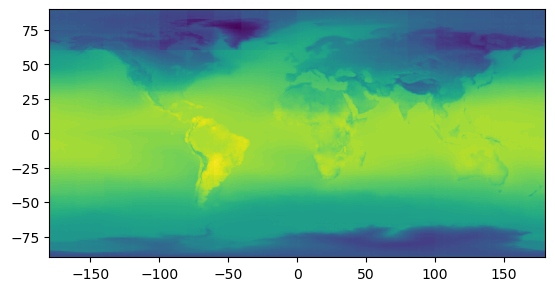

In [39]:
t2m = out[0, 12].cpu().numpy()

lat = np.linspace(-90, 90, out.shape[-2])
lon = np.linspace(-180, 180, out.shape[-1])
X, Y = np.meshgrid(lon, lat)

plt.contourf(X, Y, t2m, 100)
plt.gca().set_aspect("equal")
plt.show()